<a href="https://colab.research.google.com/github/aksh-ay06/A-B-test/blob/main/A_B_Testing_Landing_Page.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook analyzses an A/B test comparing two landing pages design to determine the redesigned page (Page B) increases user engagement. Engagement is measured by the time spent on the page, and statistical testing is used to access whether observed differnces between the two landing pages are significant.

Problem Statement : Does Landing Page B lead to higher user engagement than Landing Page A, as measured by time spent on the page?

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
import seaborn as sns



In [60]:
data = pd.read_csv("/content/web_page_data.csv")

In [61]:
data.head()

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67


In [62]:
data.describe()

,Time
count,36.000000
mean,1.411944
std,0.942407
min,0.210000
25%,0.702500
50%,1.180000
75%,1.992500
max,3.570000


In [63]:
data.isna().sum()

,0
Page,0
Time,0


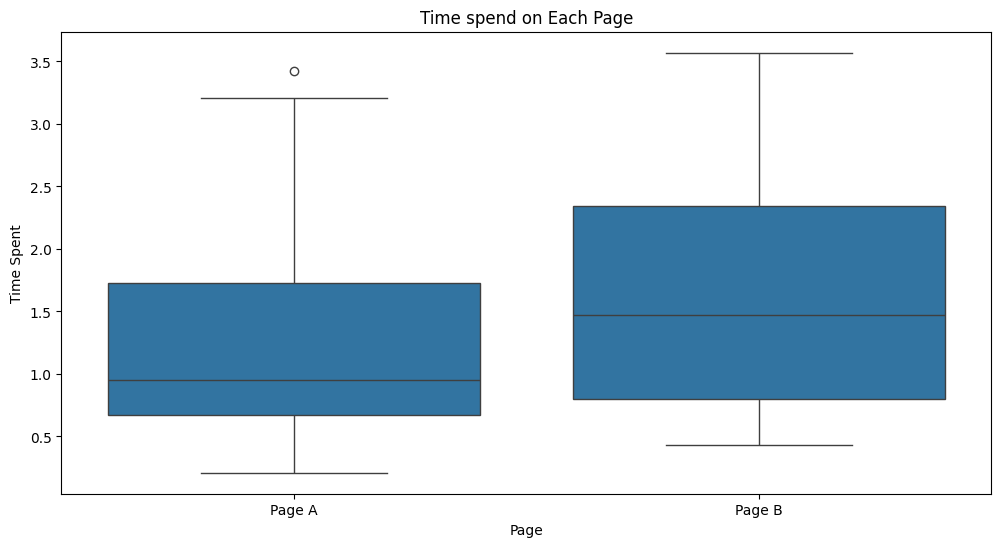

In [64]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Page',y='Time',data=data)
plt.title("Time spend on Each Page")
plt.xlabel("Page")
plt.ylabel("Time Spent")
plt.show()

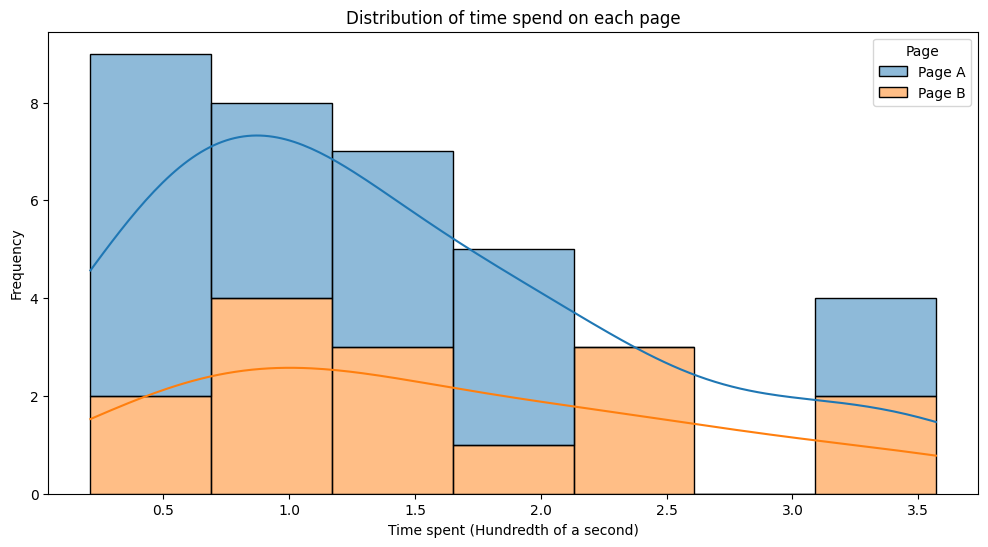

In [65]:
from IPython.core.interactiveshell import page
plt.figure(figsize=(12,6))
sns.histplot(data=data,x='Time',hue='Page',kde=True,multiple='stack')
plt.title('Distribution of time spend on each page')
plt.xlabel('Time spent (Hundredth of a second)')
plt.ylabel('Frequency')
plt.show()

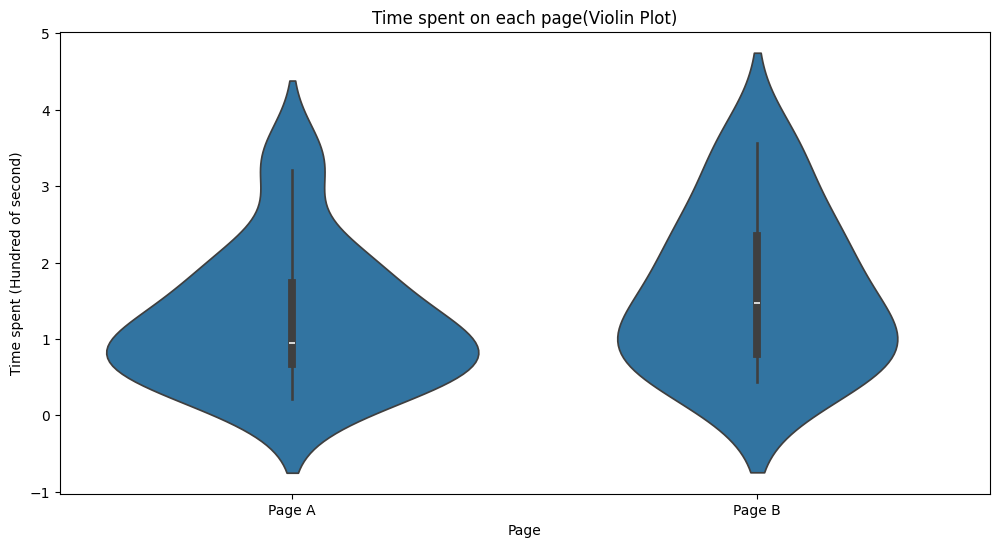

In [66]:
plt.figure(figsize=(12,6))
sns.violinplot(x='Page',y='Time',data=data)
plt.title("Time spent on each page(Violin Plot)")
plt.xlabel('Page')
plt.ylabel('Time spent (Hundred of second)')
plt.show()

Hypothesis Testing

In [67]:
data["Page"] = data["Page"].astype(str).str.strip()

# Quick sanity checks

In [68]:
print("Unique Page labels:", data["Page"].unique())
print("Rows per page:\n", data["Page"].value_counts(), "\n")

Unique Page labels: ['Page A' 'Page B']
Rows per page:
 Page
Page A    21
Page B    15
Name: count, dtype: int64 



Convert minutes -> seconds (dataset is in minutes)

In [69]:
data["seconds"] = data["Time"] * 60

Group Seperation

Split the data into two independent groups:
Page A users
Page B users

In [70]:
page_A = data.loc[data["Page"] == "Page A", "seconds"]
page_B = data.loc[data["Page"] == "Page B", "seconds"]

Guard rails (prevents NaN tests)

In [71]:
assert len(page_A) > 0 and len(page_B) > 0, "One or both groups are empty. Check Page labels."
assert page_A.notna().all() and page_B.notna().all(), "Missing values found in groups."

In [72]:
print(f"n(Page A)={len(page_A)}, n(Page B)={len(page_B)}")
print("Mean seconds (A,B):", page_A.mean(), page_B.mean())
print("Median seconds (A,B):", page_A.median(), page_B.median(), "\n")

n(Page A)=21, n(Page B)=15
Mean seconds (A,B): 75.79999999999998 97.2
Median seconds (A,B): 57.0 88.2 



We assess distributional assumptions before choosing a test.

Normality Test (Shapiro–Wilk)

H0: Data is normally distributed

H1: Data is not normally distributed

In [73]:
def shapiro_test(x, name):
    stat, p = stats.shapiro(x)
    print(f"Shapiro {name}: W={stat:.4f}, p={p:.4f}")
    return p

In [74]:
pA = shapiro_test(page_A, "Page A")
pB = shapiro_test(page_B, "Page B")


Shapiro Page A: W=0.8842, p=0.0175
Shapiro Page B: W=0.9149, p=0.1612


Variance Homogeneity Test (Levene’s Test)

H0: Variances are equal across groups

H1: Variances differ across groups

In [80]:
lev_stat, lev_p = stats.levene(page_A, page_B, center="median")

print(f"\nLevene (median-centered): stat={lev_stat:.4f}, p={lev_p:.4f}")


Levene (median-centered): stat=0.5279, p=0.4725


Research Question:

Do users spend more time on Landing Page B than on Landing Page A?

Hypotheses:

H0 (Null Hypothesis): Users spend the same amount of time on Page A and Page B.

H1 (Alternative Hypothesis): Users spend more time on Page B than on Page A.

Statistical Test:

We use the Mann–Whitney U test because engagement time may not be normally distributed.

The test is one-sided, testing whether Page B > Page A.

In scipy, this corresponds to alternative="less" when passing (Page A, Page B).

In [76]:
u_stat, p_mwu = stats.mannwhitneyu(page_A, page_B, alternative="less")
print(f"\nMann–Whitney U (H1: B > A): U={u_stat:.4f}, p={p_mwu:.4f}")


Mann–Whitney U (H1: B > A): U=119.5000, p=0.1144


In [77]:
alpha = 0.05
if p_mwu < alpha:
    print("Reject H0: Evidence suggests Page B has higher engagement time than Page A.")
else:
    print("Fail to reject H0: Not enough evidence that Page B increases engagement time over Page A.")

Fail to reject H0: Not enough evidence that Page B increases engagement time over Page A.


Rank-biserial correlation quantifies the magnitude of the difference.

This provides practical significance beyond the p-value.

In [78]:
n1, n2 = len(page_A), len(page_B)
rank_biserial = 1 - (2 * u_stat) / (n1 * n2)
print(f"\nEffect size (rank-biserial correlation): {rank_biserial:.4f}")


Effect size (rank-biserial correlation): 0.2413


Visuals (matplotlib only)

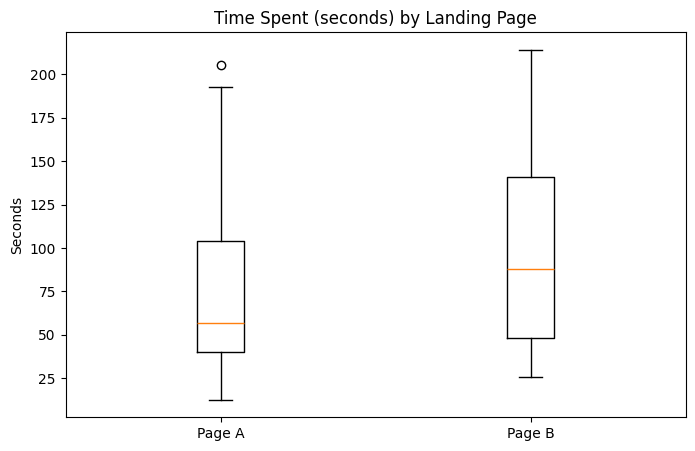

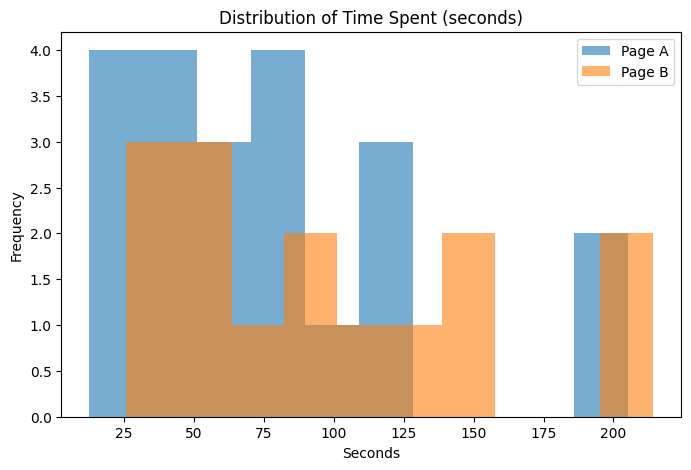

In [79]:
plt.figure(figsize=(8, 5))
plt.boxplot([page_A, page_B], tick_labels=["Page A", "Page B"])
plt.title("Time Spent (seconds) by Landing Page")
plt.ylabel("Seconds")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(page_A, bins=10, alpha=0.6, label="Page A")
plt.hist(page_B, bins=10, alpha=0.6, label="Page B")
plt.title("Distribution of Time Spent (seconds)")
plt.xlabel("Seconds")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Final Interpretation

Although Page B shows higher average and median engagement time,the Mann-Whitney U test does not provide sufficient statistical evidence at the 5% significance level to conclude that Page B significantly outperforms Page A.

This suggests the experiment may be underpowered due to:
- Small sample size
- High variance in engagement time
- Skewed distributions

Recommendation: Collect more data and consider additional engagement metrics (e.g., click-through rate, scroll depth, conversion).
